In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from IPython.display import clear_output
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import ipywidgets as widgets
from numpy.random import choice
from numpy import exp

In [2]:
# PARAMETERS
yummy_figs = [10,6]
num_people = 1000
median_income = 50000
gini = 0.25
gr = [10,20]
periods = 10
upgrade_cost_factor = 100  # This should be probably changed


In [3]:
## HELPER FUNCTIONS 

class GiniCalculationError(Exception):
    pass

def calculate_gini(incomes):
    # Calculate Gini coefficient for a list of incomes
    incomes = np.sort(incomes)
    n = len(incomes)
    index = np.arange(1, n + 1)
    return ((np.sum((2 * index - n  - 1) * incomes)) / (n * np.sum(incomes)))

def generate_income_distribution(num_people, median_income, gini_target):
    alpha = (gini_target + 1) / (2 - gini_target)  # Set initial alpha
    for _ in range(10000):  # Limit the number of iterations
        incomes = stats.gamma.rvs(alpha, scale=median_income/alpha, size=num_people)  # Generate a random income distribution
        gini_current = calculate_gini(incomes)  # Calculate the current Gini coefficient
        if np.isclose(gini_current, gini_target, atol=0.01):  # Check if the current Gini coefficient is close to the target
            return incomes
        elif gini_current < gini_target:  # If the current Gini coefficient is too low, decrease alpha
            alpha *= 0.9
        else:  # If the current Gini coefficient is too high, increase alpha
            alpha *= 1.1

    # If we've reached this point, the desired Gini coefficient was not reached
    error_message = f"Failed to reach target Gini coefficient in 1000 iterations. Current Gini: {gini_current}"
    raise GiniCalculationError(error_message)

def calculate_wealth(incomes, periods):
    # Initialize lists to hold the wealth and Gini coefficients at each time step
    wealth_over_time = []
    gini_over_time = []
    wealth_distribution_over_time = []
    
    # Calculate the wealth for each time period
    for _ in range(periods):
        # Calculate the wealth by summing the incomes
        wealth = np.sum(incomes)
        
        # Add the wealth to the list
        wealth_over_time.append(wealth)
        
        # Calculate the Gini coefficient for the current income distribution
        gini = calculate_gini(incomes)
        
        # Add the Gini coefficient to the list
        gini_over_time.append(gini)
        
        # Calculate the wealth distribution for the current income distribution
        wealth_distribution = calculate_wealth_distribution(incomes)
        
        # Add the wealth distribution to the list
        wealth_distribution_over_time.append(wealth_distribution)
        
        # Set a random growth rate for the current period
        growth_rate = np.random.uniform(gr[0], gr[1])
        
        # Increase the incomes by the growth rate
        incomes *= (1 + growth_rate)
    
    return wealth_over_time, gini_over_time, wealth_distribution_over_time


def calculate_wealth_distribution(incomes, num_bins=10):
    # Calculate the total wealth
    total_wealth = np.sum(incomes)
    
    # Calculate the histogram of wealth
    hist, bin_edges = np.histogram(incomes, bins=num_bins)
    
    # Calculate the wealth in each bin
    bin_wealths = [(bin_edges[i+1] - bin_edges[i]) * hist[i] for i in range(num_bins)]
    
    # Normalize the wealths by total wealth to get wealth distribution
    wealth_distribution = bin_wealths / total_wealth
    
    return wealth_distribution

In [4]:
# ## HELPER FUNCTIONS 

# class GiniCalculationError(Exception):
#     pass

# def calculate_gini(incomes):
#     # Calculate Gini coefficient for a list of incomes
#     incomes = np.sort(incomes)
#     n = len(incomes)
#     index = np.arange(1, n + 1)
#     return ((np.sum((2 * index - n  - 1) * incomes)) / (n * np.sum(incomes)))

# def generate_income_distribution(num_people, median_income, gini_target):
#     alpha = (gini_target + 1) / (2 - gini_target)  # Set initial alpha
#     for _ in range(10000):  # Limit the number of iterations
#         incomes = stats.gamma.rvs(alpha, scale=median_income/alpha, size=num_people)  # Generate a random income distribution
#         gini_current = calculate_gini(incomes)  # Calculate the current Gini coefficient
#         if np.isclose(gini_current, gini_target, atol=0.01):  # Check if the current Gini coefficient is close to the target
#             return incomes
#         elif gini_current < gini_target:  # If the current Gini coefficient is too low, decrease alpha
#             alpha *= 0.9
#         else:  # If the current Gini coefficient is too high, increase alpha
#             alpha *= 1.1

#     # If we've reached this point, the desired Gini coefficient was not reached
#     error_message = f"Failed to reach target Gini coefficient in 1000 iterations. Current Gini: {gini_current}"
#     raise GiniCalculationError(error_message)

# def calculate_wealth(incomes, periods):
#     # Initialize lists to hold the wealth and Gini coefficients at each time step
#     wealth_over_time = []
#     gini_over_time = []
#     wealth_distribution_over_time = []
    
#     # Calculate the wealth for each time period
#     for _ in range(periods):
#         # Calculate the wealth by summing the incomes
#         wealth = np.sum(incomes)
        
#         # Add the wealth to the list
#         wealth_over_time.append(wealth)
        
#         # Calculate the Gini coefficient for the current income distribution
#         gini = calculate_gini(incomes)
        
#         # Add the Gini coefficient to the list
#         gini_over_time.append(gini)
        
#         # Calculate the wealth distribution for the current income distribution
#         wealth_distribution = calculate_wealth_distribution(incomes)
        
#         # Add the wealth distribution to the list
#         wealth_distribution_over_time.append(wealth_distribution)
        
#         # Set a random growth rate for the current period
#         growth_rate = np.random.uniform(gr[0], gr[1])
        
#         # Increase the incomes by the growth rate
#         incomes *= (1 + growth_rate)
    
#     return wealth_over_time, gini_over_time, wealth_distribution_over_time


# def calculate_wealth_distribution(incomes, num_bins=10):
#     # Calculate the total wealth
#     total_wealth = np.sum(incomes)
    
#     # Calculate the histogram of wealth
#     hist, bin_edges = np.histogram(incomes, bins=num_bins)
    
#     # Calculate the wealth in each bin
#     bin_wealths = [(bin_edges[i+1] - bin_edges[i]) * hist[i] for i in range(num_bins)]
    
#     # Normalize the wealths by total wealth to get wealth distribution
#     wealth_distribution = bin_wealths / total_wealth
    
#     return wealth_distribution

# class Person(Agent):
#     def __init__(self, unique_id, model, initial_income, inability = False, arrears = False, dwellings = "good"):
#         super().__init__(unique_id, model)
#         self.disposable_income = initial_income
#         self.wealth = 0  # The wealth is now separate from income
#         self.energy_set = "bad"  # Assume everyone starts with a 'bad' energy set
#         self.inability = inability
#         self.dwellings = dwellings  # Assume everyone starts with bad dwelling conditions
#         self.arrears = arrears  # Assume no one has arrears to start
#         self.consumption = self.random.uniform(0.05, 0.15)  # Energy consumption as a percentage of wealth
#         self.energy_cost = 0  # Will be calculated each step based on energy_set

#     def step(self):
#         # Check if the person can afford to switch to 'good' energy set
#         if self.energy_set == "bad" and self.wealth > self.model.switch_cost:
#             # Calculate potential savings from switching
#             potential_savings = self.wealth * self.consumption * (self.model.bad_energy_cost_factor - self.model.good_energy_cost_factor) * self.model.switch_cost_payback
#             if potential_savings > self.model.switch_cost:
#                 # If potential savings are greater than the switch cost, switch to 'good' energy set
#                 self.energy_set = "good"
#                 self.wealth -= self.model.switch_cost  # Pay the cost to switch

#                 # Recalculate inability and arrears only after initialization (step 0)
#         if self.model.schedule.steps > 0:
#             # Calculate energy cost based on energy set, consumption and renewable energy share
#             cost_factor = self.model.bad_energy_cost_factor if self.energy_set == "bad" else self.model.good_energy_cost_factor
#             renewable_factor = 1 / (1 + self.model.renewable_share)
#             self.energy_cost = self.wealth * self.consumption * cost_factor * renewable_factor

#             # Check if the person falls into energy poverty (if energy cost >= 2 * median energy cost of all agents)
#             median_energy_cost = np.median([a.energy_cost for a in self.model.schedule.agents])
#             is_2M = self.energy_cost >= 2 * median_energy_cost

#             # Update inability
#             self.inability = self.dwellings == "bad" or is_2M

#             # Update arrears
#             if self.energy_cost > 0.6 * self.disposable_income:
#                 # Can't pay energy cost from disposable income, try to use wealth
#                 if self.energy_cost > 0.75 * self.wealth:
#                     # Can't pay from wealth either, goes into arrears
#                     self.arrears = True
#                     self.energy_cost = 0  # Can't pay the energy cost
#                 else:
#                     # Can pay from wealth
#                     self.wealth -= self.energy_cost
#                     self.energy_cost = 0  # Energy cost has been paid
#             else:
#                 # Can pay from disposable income
#                 self.disposable_income -= self.energy_cost
#                 self.energy_cost = 0  # Energy cost has been paid

#         # Calculate energy cost based on energy set, consumption and renewable energy share
#         cost_factor = self.model.bad_energy_cost_factor if self.energy_set == "bad" else self.model.good_energy_cost_factor
#         renewable_factor = 1 / (1 + self.model.renewable_share)
#         self.energy_cost = self.wealth * self.consumption * cost_factor * renewable_factor
            
#         # Subtract energy cost from disposable income
#         self.disposable_income -= self.energy_cost

#         # Add remaining disposable income to wealth
#         self.wealth += self.disposable_income

#         # Check if the person falls into energy poverty (if energy cost >= 2 * median energy cost of all agents)
#         median_energy_cost = np.median([a.energy_cost for a in self.model.schedule.agents])
#         if self.energy_cost >= 2 * median_energy_cost:
#             # Take some action if the person falls into energy poverty
#             pass  # Placeholder for energy poverty action



# class Economy(Model):
#     def __init__(self, num_people, median_income, gini_target, tech_progress_rate, renewable_share, switch_cost, switch_cost_payback,bad_energy_cost_factor, good_energy_cost_factor,growth_bounds, rd_share, rd_min):
#         self.num_people = num_people
#         self.tech_progress = 0  # Start with no technological progress
#         self.tech_progress_rate = tech_progress_rate  # Rate at which technological progress occurs each step
#         self.renewable_share = renewable_share  # Proportion of energy that comes from renewable sources
#         self.switch_cost = switch_cost  # Cost for an agent to switch to the 'good' energy set
#         self.switch_cost_payback = switch_cost_payback  # How many steps it takes for the switch cost to pay back in savings
#         self.bad_energy_cost_factor = bad_energy_cost_factor # dont forhet to comment this
#         self.good_energy_cost_factor = good_energy_cost_factor # dont forget to comment this
#         self.growth_bounds = growth_bounds  # Bounds for random economic growth
#         self.economic_growth = 0
#         self.rd_share = rd_share  # Share of economic growth allocated to R&D
#         self.rd_min = rd_min # research and development investments 
#         self.schedule = RandomActivation(self)
        
#         incomes = generate_income_distribution(num_people, median_income, gini_target)
#         sorted_incomes = np.sort(incomes)


#         # Define lower and middle income groups (you can adjust the thresholds as needed)
#         lower_income_threshold = np.percentile(sorted_incomes, 20)  # Bottom 20%
#         middle_income_threshold = np.percentile(sorted_incomes, 50)  # Up to 50%

#         lower_income_group = sorted_incomes[sorted_incomes < lower_income_threshold]
#         middle_income_group = sorted_incomes[(sorted_incomes >= lower_income_threshold) & (sorted_incomes < middle_income_threshold)]

#         # Combine lower and middle income groups, with lower income group having more weight
#         combined_group = np.concatenate([lower_income_group, middle_income_group])
#         weights = [0.75 if income < lower_income_threshold else 0.25 for income in combined_group]

#         # Normalize the weights
#         weights = weights / np.sum(weights)

#         # Randomly assign inability, arrears, and dwellings based on weights
#         inability_group = choice(combined_group, size=int(num_people * 0.15), replace=False, p=weights)  # 15% of agents with inability
#         arrears_group = choice(combined_group, size=int(num_people * 0.07), replace=False, p=weights)  # 7% of agents with arrears
#         bad_dwellings_group = choice(combined_group, size=int(num_people * 0.07), replace=False, p=weights)  # 7% of agents with bad dwellings

#         for i in range(num_people):
#             inability = incomes[i] in inability_group
#             arrears = incomes[i] in arrears_group
#             dwellings = "bad" if incomes[i] in bad_dwellings_group else "good"
#             a = Person(i, self, incomes[i], inability, arrears, dwellings)
#             self.schedule.add(a)

        
#         self.datacollector = DataCollector(
#             model_reporters={
#                 "Total Wealth": lambda m: sum([agent.wealth for agent in m.schedule.agents]), 
#                 "Gini": lambda m: calculate_gini([agent.wealth for agent in m.schedule.agents]),
#                 "Wealth Distribution": lambda m: calculate_wealth_distribution([agent.wealth for agent in m.schedule.agents]),
#                 "2M indicator": lambda m: len([agent for agent in m.schedule.agents if agent.energy_cost >= 2 * np.median([a.energy_cost for a in m.schedule.agents])]),
#                 "Energy Poverty": lambda m: (sum([0.5*agent.inability + 0.25*(agent.dwellings=="bad") + 0.25*agent.arrears for agent in m.schedule.agents]) / m.num_people) * 100,
#                 "Tech Progress": lambda m: m.tech_progress,
#                 "Growth": lambda m: m.economic_growth,
#             },
#             agent_reporters={
#                 "Wealth": lambda a: a.wealth,
#                 "Energy Cost": lambda a: a.energy_cost
#             }
#         )

#     def step(self):
#         '''Advance the model by one step.'''
#         self.datacollector.collect(self)
        
#         # Determine the economic growth for this step
#         self.economic_growth = np.random.uniform(self.growth_bounds[0], self.growth_bounds[1])
        
#         # Update disposable income of the economy
#         for agent in self.schedule.agents:
#             agent.disposable_income *= (1 + self.economic_growth / 100)
#             agent.consumption *= (1 - self.tech_progress)

#         # Allocate a portion of the growth to R&D, and add it to technological progress
#         rd_investment = max(self.economic_growth * self.rd_share, self.rd_min)
#         self.tech_progress += rd_investment

#         self.schedule.step()

In [5]:
# # Instantiate and run model
# model = Economy(1000, 18000, 0.25, 0.01, 0.2,100,2, #people, median_income, gini, tech progress, RES share, switch cost, switch_cost_payback (no of steps), 
#                 2,1,[0.05,0.1],0.03,0.01) # bad_energy_cost_factor, good_energy_cost_factor, growth_bounds, rd_share, rd_min 

# for i in range(periods):
#     model.step()

# # Access the collected data
# model_df = model.datacollector.get_model_vars_dataframe()
# agent_df = model.datacollector.get_agent_vars_dataframe()

In [6]:
# import matplotlib.pyplot as plt

# # Plot total wealth over time
# plt.figure(figsize=(10,6))
# plt.plot(model_df["Total Wealth"])
# plt.title('Total Wealth over Time')
# plt.xlabel('Steps')
# plt.ylabel('Total Wealth')


# # Plot Gini coefficient over time
# plt.figure(figsize=(10,6))
# plt.plot(model_df["Gini"])
# plt.title('Gini Coefficient over Time')
# plt.xlabel('Steps')
# plt.ylabel('Gini Coefficient')


# # Plot number of agents in energy poverty over time
# plt.figure(figsize=(10,6))
# plt.plot(model_df["2M indicator"])
# plt.title('2M indicator - Number of Agents')
# plt.xlabel('Steps')
# plt.ylabel('Number of Agents in Energy Poverty')

# # Plot number of agents in energy poverty over time
# plt.figure(figsize=(10,6))
# plt.plot(model_df["Growth"])
# plt.title('Growth over time')
# plt.xlabel('Steps')
# plt.ylabel('Growth %')


# # Plot number of agents in energy poverty over time
# plt.figure(figsize=(10,6))
# plt.plot(model_df["Energy Poverty"])
# plt.title('Energy Poverty - Number of Agents')
# plt.xlabel('Steps')
# plt.ylabel('Number of Agents in Energy Poverty')

# # Plot technological progress over time
# plt.figure(figsize=(10,6))
# plt.plot(model_df["Tech Progress"])
# plt.title('Technological Progress over Time')
# plt.xlabel('Steps')
# plt.ylabel('Technological Progress')

# # Adjust layout for better spacing
# plt.tight_layout()

# plt.show()

In [7]:
# # Get agent data for the final step
# final_step_data = agent_df.xs(periods-1, level="Step")

# # Plot histogram of wealth distribution at the final step
# plt.figure(figsize=(10,6))
# plt.hist(final_step_data["Wealth"], bins=20, edgecolor='black')
# plt.title('Wealth Distribution at Final Step')
# plt.xlabel('Wealth')
# plt.ylabel('Number of Agents')
# plt.show()

# # Plot histogram of energy costs at the final step
# plt.figure(figsize=(10,6))
# plt.hist(final_step_data["Energy Cost"], bins=20, edgecolor='black')
# plt.title('Energy Cost Distribution at Final Step')
# plt.xlabel('Energy Cost')
# plt.ylabel('Number of Agents')
# plt.show()


In [8]:
# import matplotlib.pyplot as plt

# # Retrieve model-level variables from the datacollector
# model_df = model.datacollector.get_model_vars_dataframe()

# # Create a new figure
# plt.figure(figsize=(10, 6))

# # Plot total wealth over time
# plt.subplot(2, 2, 1)
# plt.plot(model_df['Total Wealth'])
# plt.title('Total Wealth Over Time')

# # Plot Gini coefficient over time
# plt.subplot(2, 2, 2)
# plt.plot(model_df['Gini'])
# plt.title('Gini Coefficient Over Time')

# # Plot wealth distribution at the final step
# plt.subplot(2, 2, 3)
# plt.hist(agent_df.xs(periods - 1, level="Step")["Wealth"], bins=10, alpha=0.5)
# plt.title('Wealth Distribution at Final Step')

# # Adjust layout for better spacing
# plt.tight_layout()

# # Show the plots
# plt.show()


In [9]:
# ## PLOTS 

# def plot_wealth_over_time(wealth_over_time):
#     plt.figure(figsize=(10,6))
#     plt.plot(wealth_over_time)
#     plt.xlabel('Time')
#     plt.ylabel('Wealth')
#     plt.title('Total wealth over time')
#     plt.show()

# def plot_wealth_distribution(wealth_distribution):
#     plt.figure(figsize=(10,6))
#     plt.bar(range(1, 11), wealth_distribution)
#     plt.xlabel('Quintile')
#     plt.ylabel('Wealth')
#     plt.title('Wealth distribution')
#     plt.show()

# def plot_lorenz_curve(X, yummy_figs = yummy_figs):

#     X_sorted = np.sort(X)  # Sort the incomes
#     lorenz = np.cumsum(X_sorted) / np.sum(X_sorted)
#     lorenz = np.insert(lorenz, 0, 0)
#     lorenz[0], lorenz[-1]

#     fig, ax = plt.subplots(figsize=[yummy_figs[0],yummy_figs[1]])
#     ax.scatter(np.arange(lorenz.size)/(lorenz.size-1), lorenz, 
#             marker='.', color='darkgreen', s=100)
#     ## line plot of equality
#     plt.title("Lorenz Curve")
#     ax.plot([0,1], [0,1], color='k')
#     plt.show()

In [10]:
# @widgets.interact
# def interactive_plots(t=widgets.IntSlider(min=0, max=model.schedule.steps-1, step=1, value=0)):
#     time_step = t
#     clear_output(wait=True)
#     wealth_dist = model_df.loc[time_step, "Wealth Distribution"]
#     total_wealth = model_df.loc[time_step, "Total Wealth"]
#     gini_data =  model_df.loc[time_step, "Gini"]
#     incomes = agent_df.loc[time_step, "Wealth"]
#     ep_agent = agent_df.loc[time_step,"Energy Cost"]
    
#     # Plot the wealth distribution
#     plot_wealth_distribution(wealth_dist)
    
#     # Plot the Lorenz curve
#     plot_lorenz_curve(incomes)

In [11]:
# from mesa import Agent, Model
# from mesa.time import RandomActivation
# from mesa.datacollection import DataCollector
# from IPython.display import clear_output
# import numpy as np
# import scipy.stats as stats
# import matplotlib.pyplot as plt
# import random
# import ipywidgets as widgets
# from numpy.random import choice
# from math import exp


# # PARAMETERS
# yummy_figs = [10,6]
# num_people = 1000
# median_income = 50000
# gini = 0.25
# gr = [10,20]
# periods = 10
# tech_quality_scale = 25
# dwelling_quality_scale = 25
# upgrade_cost_factor = 100  # Cost factor for upgrades


# class Person(Agent):
#     def __init__(self, unique_id, model, initial_income, inability = False, arrears = False, dwellings = 25, technology = 25):
#         super().__init__(unique_id, model)
#         self.disposable_income = initial_income
#         self.wealth = 0  # The wealth is now separate from income
#         self.energy_set = "bad"  # Assume everyone starts with a 'bad' energy set
#         self.inability = inability
#         self.dwellings = dwellings  # Assume everyone starts with low quality dwelling
#         self.technology = technology  # Assume everyone starts with low quality technology
#         self.arrears = arrears  # Assume no one has arrears to start
#         self.energy_cost = 0  # Will be calculated each step based on energy_set and quality


#     def minimal_energy_consumption(self):
#         # Define how dwelling and technology quality affect energy consumption
#         return self.dwellings * self.technology / 10000  # Replace this formula as needed

#     def step(self):
#         # Check if the person can afford to upgrade dwelling or technology
#         dwelling_upgrade_cost = upgrade_cost_factor * exp(self.dwellings / 100)
#         technology_upgrade_cost = upgrade_cost_factor * exp(self.technology / 100)

#         # Determine which upgrade is more beneficial (reduces energy cost more)
#         dwelling_savings = self.energy_cost * (self.dwellings / 100)
#         technology_savings = self.energy_cost * (self.technology / 100)

#         if dwelling_savings > dwelling_upgrade_cost and dwelling_savings > technology_savings:
#             # If potential savings from upgrading dwelling are greater than the cost and more than from upgrading technology, upgrade dwelling
#             self.dwellings += 1
#             self.wealth -= dwelling_upgrade_cost  # Pay the cost to upgrade
#         elif technology_savings > technology_upgrade_cost:
#             # If potential savings from upgrading technology are greater than the cost, upgrade technology
#             self.technology += 1
#             self.wealth -= technology_upgrade_cost  # Pay the cost to upgrade

#         # Check if the person can afford to switch to 'good' energy set
#         if self.energy_set == "bad" and self.wealth > self.model.switch_cost:
#             # Calculate potential savings from switching
#             potential_savings = self.wealth * self.minimal_energy_consumption() * (self.model.bad_energy_cost_factor - self.model.good_energy_cost_factor) * self.model.switch_cost_payback
#             if potential_savings > self.model.switch_cost:
#                 # If potential savings are greater than the switch cost, switch to 'good' energy set
#                 self.energy_set = "good"
#                 self.wealth -= self.model.switch_cost  # Pay the cost to switch

#         # Calculate energy cost based on energy set, consumption and renewable energy share
#         cost_factor = self.model.bad_energy_cost_factor if self.energy_set == "bad" else self.model.good_energy_cost_factor
#         renewable_factor = 1 / (1 + self.model.renewable_share)
#         self.energy_cost = self.wealth * self.minimal_energy_consumption() * cost_factor * renewable_factor * (self.dwellings / 100) * (self.technology / 100)
            
#         # Subtract energy cost from disposable income
#         self.disposable_income -= self.energy_cost

#         # Add remaining disposable income to wealth
#         self.wealth += self.disposable_income

#         # Check if the person falls into energy poverty (if energy cost >= 2 * median energy cost of all agents)
#         median_energy_cost = np.median([a.energy_cost for a in self.model.schedule.agents])
#         if self.energy_cost >= 2 * median_energy_cost:
#             # Take some action if the person falls into energy poverty
#             pass  # Placeholder for energy poverty action


# class Economy(Model):
#     def __init__(self, num_people, median_income, gini_target, tech_progress_rate, renewable_share, switch_cost, switch_cost_payback,bad_energy_cost_factor, good_energy_cost_factor,growth_bounds, rd_share, rd_min):
#         self.num_people = num_people
#         self.tech_progress = 0  # Start with no technological progress
#         self.tech_progress_rate = tech_progress_rate  # Rate at which technological progress occurs each step
#         self.renewable_share = renewable_share  # Proportion of energy that comes from renewable sources
#         self.switch_cost = switch_cost  # Cost for an agent to switch to the 'good' energy set
#         self.switch_cost_payback = switch_cost_payback  # How many steps it takes for the switch cost to pay back in savings
#         self.bad_energy_cost_factor = bad_energy_cost_factor # dont forhet to comment this
#         self.good_energy_cost_factor = good_energy_cost_factor # dont forget to comment this
#         self.growth_bounds = growth_bounds  # Bounds for random economic growth
#         self.economic_growth = 0
#         self.rd_share = rd_share  # Share of economic growth allocated to R&D
#         self.rd_min = rd_min # research and development investments 
#         self.schedule = RandomActivation(self)
        
#         incomes = generate_income_distribution(num_people, median_income, gini_target)
#         sorted_incomes = np.sort(incomes)


#         # Define lower, middle and high income groups
#         lower_income_threshold = np.percentile(sorted_incomes, 20)  # Bottom 20%
#         middle_income_threshold = np.percentile(sorted_incomes, 50)  # Up to 50%
#         high_income_threshold = np.percentile(sorted_incomes, 80)  # Up to 80%


#         lower_income_group = sorted_incomes[sorted_incomes < lower_income_threshold]
#         middle_income_group = sorted_incomes[(sorted_incomes >= lower_income_threshold) & (sorted_incomes < middle_income_threshold)]
#         high_income_group = sorted_incomes[(sorted_incomes >= middle_income_threshold) & (sorted_incomes < high_income_threshold)]
        

#         # Combine lower, middle and high income groups, with lower income group having more weight
#         combined_group = np.concatenate([lower_income_group, middle_income_group, high_income_group])
#         weights = [0.75 if income < lower_income_threshold else 0.5 if income < middle_income_threshold else 0.25 for income in combined_group]


#         # Normalize the weights
#         weights = weights / np.sum(weights)

#         # Randomly assign inability, arrears, and dwellings based on weights
#         inability_group = choice(combined_group, size=int(num_people * 0.15), replace=False, p=weights)  # 15% of agents with inability
#         arrears_group = choice(combined_group, size=int(num_people * 0.07), replace=False, p=weights)  # 7% of agents with arrears
#         # Randomly assign bad dwellings and bad technologies based on weights
#         bad_dwellings_group = choice(combined_group, size=int(num_people * 0.07), replace=False, p=weights)  # 7% of agents with bad dwellings
#         bad_technologies_group = choice(combined_group, size=int(num_people * 0.07), replace=False, p=weights)  # 7% of agents with bad technologies


#         for i in range(num_people):
#             inability = incomes[i] in inability_group
#             arrears = incomes[i] in arrears_group
#             # Now we determine the quality score for dwelling and technology based on income percentile
#             income_percentile = stats.percentileofscore(sorted_incomes, incomes[i])

#             # Agents in bad dwellings or with bad technologies start with a score of 25
#             # Others start with a score of 25 + income percentile * proportionality parameter
#             dwellings = 25 if incomes[i] in bad_dwellings_group else 25 + income_percentile * 0.5  # Proportionality parameter for dwellings is 0.5
#             technology = 25 if incomes[i] in bad_technologies_group else 25 + income_percentile * 0.75  # Proportionality parameter for technology is 0.75


#             a = Person(i, self, incomes[i], inability, arrears, dwellings, technology)
#             self.schedule.add(a)

        
#         self.datacollector = DataCollector(
#             model_reporters={
#                 "Total Wealth": lambda m: sum([agent.wealth for agent in m.schedule.agents]), 
#                 "Gini": lambda m: calculate_gini([agent.wealth for agent in m.schedule.agents]),
#                 "Wealth Distribution": lambda m: calculate_wealth_distribution([agent.wealth for agent in m.schedule.agents]),
#                 "2M indicator": lambda m: len([agent for agent in m.schedule.agents if agent.energy_cost >= 2 * np.median([a.energy_cost for a in m.schedule.agents])]),
#                 "Energy Poverty": lambda m: (sum([0.5*agent.inability + 0.25*(agent.dwellings=="bad") + 0.25*agent.arrears for agent in m.schedule.agents]) / m.num_people) * 100,
#                 "Tech Progress": lambda m: m.tech_progress,
#                 "Growth": lambda m: m.economic_growth,
#             },
#             agent_reporters={
#                 "Wealth": lambda a: a.wealth,
#                 "Energy Cost": lambda a: a.energy_cost
#             }
#         )

#     def step(self):
#         '''Advance the model by one step.'''
#         self.datacollector.collect(self)
        
#         # Determine the economic growth for this step
#         self.economic_growth = np.random.uniform(self.growth_bounds[0], self.growth_bounds[1])
        
#         # Update disposable income of the economy
#         for agent in self.schedule.agents:
#             agent.disposable_income *= (1 + self.economic_growth / 100)
#             agent.minimal_energy_consumption() *= (1 - self.tech_progress)  # Adjusted this line

#         # Allocate a portion of the growth to R&D, and add it to technological progress
#         rd_investment = max(self.economic_growth * self.rd_share, self.rd_min)
#         self.tech_progress += rd_investment

#         self.schedule.step()



In [12]:
class Person(Agent):
    def __init__(self, unique_id, model, initial_income, inability = False, arrears = False, dwellings = 25, technology = 25, upgrade_cost_factor=100): ## THE HARDCODED VALUES SHOULD BE CHANGED LATER
        super().__init__(unique_id, model)
        self.disposable_income = initial_income
        self.wealth = 0  # The wealth is now separate from income
        self.energy_set = "bad"  # Assume everyone starts with a 'bad' energy set
        self.inability = inability
        self.dwellings = dwellings  # Assume everyone starts with low quality dwelling
        self.technology = technology  # Assume everyone starts with low quality technology
        self.arrears = arrears  # Assume no one has arrears to start
        self.energy_cost = 0  # Will be calculated each step based on energy_set and quality

    def minimal_energy_consumption(self):
        # Define how dwelling and technology quality affect energy consumption
        return self.dwellings * self.technology / 10000  # Replace this formula as needed

    def step(self):
        # Check if the person can afford to upgrade dwelling or technology
        dwelling_upgrade_cost = upgrade_cost_factor * exp(self.dwellings / 100)
        technology_upgrade_cost = upgrade_cost_factor * exp(self.technology / 100)

        # Determine which upgrade is more beneficial (reduces energy cost more)
        dwelling_savings = self.energy_cost * (self.dwellings / 100)
        technology_savings = self.energy_cost * (self.technology / 100)

        if dwelling_savings > dwelling_upgrade_cost and dwelling_savings > technology_savings:
            # If potential savings from upgrading dwelling are greater than the cost and more than from upgrading technology, upgrade dwelling
            self.dwellings += 1
            self.wealth -= dwelling_upgrade_cost  # Pay the cost to upgrade
        elif technology_savings > technology_upgrade_cost:
            # If potential savings from upgrading technology are greater than the cost, upgrade technology
            self.technology += 1
            self.wealth -= technology_upgrade_cost  # Pay the cost to upgrade

        # Check if the person can afford to switch to 'good' energy set
        if self.energy_set == "bad" and self.wealth > self.model.switch_cost:
            # Calculate potential savings from switching
            potential_savings = self.wealth * self.minimal_energy_consumption() * (self.model.bad_energy_cost_factor - self.model.good_energy_cost_factor) * self.model.switch_cost_payback
            if potential_savings > self.model.switch_cost:
                # If potential savings are greater than the switch cost, switch to 'good' energy set
                self.energy_set = "good"
                self.wealth -= self.model.switch_cost  # Pay the cost to switch

        # Calculate energy cost based on energy set, minimal energy consumption and renewable energy share
        cost_factor = self.model.bad_energy_cost_factor if self.energy_set == "bad" else self.model.good_energy_cost_factor
        renewable_factor = 1 / (1 + self.model.renewable_share)
        self.energy_cost = self.wealth * self.minimal_energy_consumption() * (1 - self.model.tech_progress) * cost_factor * renewable_factor

        # Subtract energy cost from disposable income
        self.disposable_income -= self.energy_cost

        # Add remaining disposable income to wealth
        self.wealth += self.disposable_income

        # Check if the person falls into energy poverty (if energy cost >= 2 * median energy cost of all agents)
        median_energy_cost = np.median([a.energy_cost for a in self.model.schedule.agents])
        if self.energy_cost >= 2 * median_energy_cost:
            # Take some action if the person falls into energy poverty
            pass  # Placeholder for energy poverty action

class Economy(Model):
    def __init__(self, num_people, median_income, gini_target, tech_progress_rate, renewable_share, switch_cost, switch_cost_payback,bad_energy_cost_factor, good_energy_cost_factor,growth_bounds, rd_share, rd_min):
        self.num_people = num_people
        self.tech_progress = 0  # Start with no technological progress
        self.tech_progress_rate = tech_progress_rate  # Rate at which technological progress occurs each step
        self.renewable_share = renewable_share  # Proportion of energy that comes from renewable sources
        self.switch_cost = switch_cost  # Cost for an agent to switch to the 'good' energy set
        self.switch_cost_payback = switch_cost_payback  # How many steps it takes for the switch cost to pay back in savings
        self.bad_energy_cost_factor = bad_energy_cost_factor # dont forhet to comment this
        self.good_energy_cost_factor = good_energy_cost_factor # dont forget to comment this
        self.growth_bounds = growth_bounds  # Bounds for random economic growth
        self.economic_growth = 0
        self.rd_share = rd_share  # Share of economic growth allocated to R&D
        self.rd_min = rd_min # research and development investments 
        self.schedule = RandomActivation(self)
        
        incomes = generate_income_distribution(num_people, median_income, gini_target)
        sorted_incomes = np.sort(incomes)


        # Define lower, middle and high income groups
        lower_income_threshold = np.percentile(sorted_incomes, 20)  # Bottom 20%
        middle_income_threshold = np.percentile(sorted_incomes, 50)  # Up to 50%
        high_income_threshold = np.percentile(sorted_incomes, 80)  # Up to 80%


        lower_income_group = sorted_incomes[sorted_incomes < lower_income_threshold]
        middle_income_group = sorted_incomes[(sorted_incomes >= lower_income_threshold) & (sorted_incomes < middle_income_threshold)]
        high_income_group = sorted_incomes[(sorted_incomes >= middle_income_threshold) & (sorted_incomes < high_income_threshold)]
        

        # Combine lower, middle and high income groups, with lower income group having more weight
        combined_group = np.concatenate([lower_income_group, middle_income_group, high_income_group])
        weights = [0.75 if income < lower_income_threshold else 0.5 if income < middle_income_threshold else 0.25 for income in combined_group]


        # Normalize the weights
        weights = weights / np.sum(weights)

        # Randomly assign inability, arrears, and dwellings based on weights
        inability_group = choice(combined_group, size=int(num_people * 0.15), replace=False, p=weights)  # 15% of agents with inability
        arrears_group = choice(combined_group, size=int(num_people * 0.07), replace=False, p=weights)  # 7% of agents with arrears
        # Randomly assign bad dwellings and bad technologies based on weights
        bad_dwellings_group = choice(combined_group, size=int(num_people * 0.07), replace=False, p=weights)  # 7% of agents with bad dwellings
        bad_technologies_group = choice(combined_group, size=int(num_people * 0.07), replace=False, p=weights)  # 7% of agents with bad technologies


        for i in range(num_people):
            inability = incomes[i] in inability_group
            arrears = incomes[i] in arrears_group
            # Now we determine the quality score for dwelling and technology based on income percentile
            income_percentile = stats.percentileofscore(sorted_incomes, incomes[i])

            # Agents in bad dwellings or with bad technologies start with a score of 25
            # Others start with a score of 25 + income percentile * proportionality parameter
            dwellings = 25 if incomes[i] in bad_dwellings_group else 25 + income_percentile * 0.5  # Proportionality parameter for dwellings is 0.5
            technology = 25 if incomes[i] in bad_technologies_group else 25 + income_percentile * 0.75  # Proportionality parameter for technology is 0.75


            a = Person(i, self, incomes[i], inability, arrears, dwellings, technology,upgrade_cost_factor)
            self.schedule.add(a)

        
        self.datacollector = DataCollector(
            model_reporters={
                "Total Wealth": lambda m: sum([agent.wealth for agent in m.schedule.agents]), 
                "Gini": lambda m: calculate_gini([agent.wealth for agent in m.schedule.agents]),
                "Wealth Distribution": lambda m: calculate_wealth_distribution([agent.wealth for agent in m.schedule.agents]),
                "2M indicator": lambda m: len([agent for agent in m.schedule.agents if agent.energy_cost >= 2 * np.median([a.energy_cost for a in m.schedule.agents])]),
                "Energy Poverty": lambda m: (sum([0.5*agent.inability + 0.25*(agent.dwellings=="bad") + 0.25*agent.arrears for agent in m.schedule.agents]) / m.num_people) * 100,
                "Tech Progress": lambda m: m.tech_progress,
                "Growth": lambda m: m.economic_growth,
            },
            agent_reporters={
                "Wealth": lambda a: a.wealth,
                "Energy Cost": lambda a: a.energy_cost
            }
        )
    def step(self):
        '''Advance the model by one step.'''
        self.datacollector.collect(self)

        # Determine the economic growth for this step
        self.economic_growth = np.random.uniform(self.growth_bounds[0], self.growth_bounds[1])

        # Update disposable income of the economy
        for agent in self.schedule.agents:
            agent.disposable_income *= (1 + self.economic_growth / 100)

        # Allocate a portion of the growth to R&D, and add it to technological progress
        rd_investment = max(self.economic_growth * self.rd_share, self.rd_min)
        self.tech_progress += rd_investment

        self.schedule.step()


In [13]:
# Instantiate and run model
model = Economy(1000, 18000, 0.25, 0.01, 0.2,100,2, #people, median_income, gini, tech progress, RES share, switch cost, switch_cost_payback (no of steps), 
                2,1,[0.05,0.1],0.03,0.01) # bad_energy_cost_factor, good_energy_cost_factor, growth_bounds, rd_share, rd_min 

for i in range(periods):
    model.step()

# Access the collected data
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

C:\Users\novak\AppData\Local\Temp\ipykernel_20956\588165197.py:11: RuntimeWarning: invalid value encountered in long_scalars
  return ((np.sum((2 * index - n  - 1) * incomes)) / (n * np.sum(incomes)))
C:\Users\novak\AppData\Local\Temp\ipykernel_20956\588165197.py:75: RuntimeWarning: divide by zero encountered in true_divide
  wealth_distribution = bin_wealths / total_wealth
C:\Users\novak\AppData\Local\Temp\ipykernel_20956\588165197.py:75: RuntimeWarning: invalid value encountered in true_divide
  wealth_distribution = bin_wealths / total_wealth


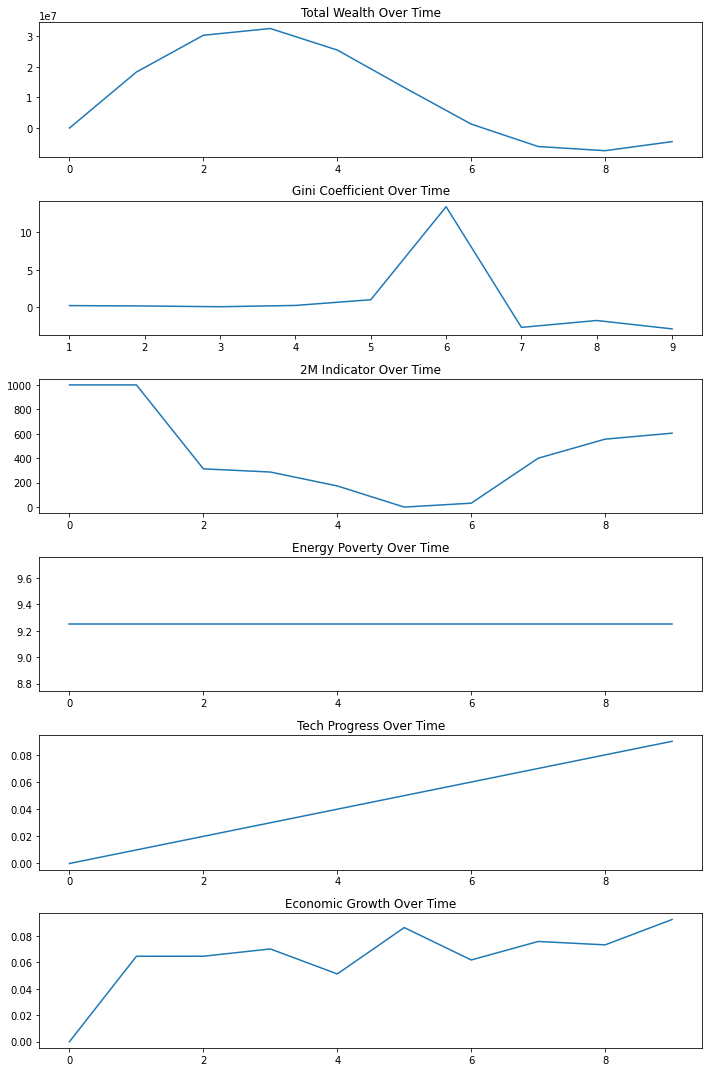

In [14]:
# Access the collected data
model_df = model.datacollector.get_model_vars_dataframe()

# Plot the data
fig, axs = plt.subplots(6, 1, figsize=(10, 15))

axs[0].plot(model_df["Total Wealth"])
axs[0].set_title("Total Wealth Over Time")

axs[1].plot(model_df["Gini"])
axs[1].set_title("Gini Coefficient Over Time")

axs[2].plot(model_df["2M indicator"])
axs[2].set_title("2M Indicator Over Time")

axs[3].plot(model_df["Energy Poverty"])
axs[3].set_title("Energy Poverty Over Time")

axs[4].plot(model_df["Tech Progress"])
axs[4].set_title("Tech Progress Over Time")

axs[5].plot(model_df["Growth"])
axs[5].set_title("Economic Growth Over Time")

# Adjust spacing and display the plot
plt.tight_layout()
plt.show()